## Usando o rENA no python

O exemplo abaixo mostra como utilizar a biblioteca do R rENA com a liguagem python.
Todas as bibliotecas do python podem ser usadas para mnipular e arrumar os dados para serem plotados.

Todas as funçoes da biblioteca podem ser chamadas usando a interface rENA, um outro detalhe ,e que os pontos (.) devem ser substituidos por underscore (_)
Exemplo:
    A função ena.plot() pode ser chamada usando rENA.ena_plot()
    A função ena.plot.points() pode ser chamada usando rENA.ena_plot_points().
    
### Bibliotecas necessárias:
    Devem ser instaladas as bibliotecas R rENA e data.table usando os comandos abaixo:
    install.packages("rENA")
    install.packages("data.table")
    
    No python devemos instalar a biblioteca rpy2 usando o seguinte comando:
    pip install rpy2
    
    

In [1]:
# -*- coding: UTF-8 -*-

from pandas import read_csv
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()  # makes some conversions automatic
from helpers import ena_plot

## Importação da biblioteca rENA do R
Suas funções estarão disponíveis na variável "rENA"

In [2]:
rENA = importr('rENA')

# Data

In [3]:
# Leitura dos dados a serem plotados
rsdata = read_csv("/home/jovyan/data/rsdata.csv")

## Identificar colunas para usar no acumulador
Antes de executar a função ena_accumulate_data, precisamos primeiro identificar quais colunas de dados usar em nossas unidades (units), conversas (conversation) e códigos (codes). Há também um parâmetro opcional de metadados (meta), que é para dados específicos da unidade que desejamos realizar no processo de acumulação e nos manter associados às unidades identificadas.

In [4]:
units = rsdata[['Condition','UserName']]
conversation = rsdata[['Condition','GroupName']]
codes = rsdata[['Data','Technical.Constraints','Performance.Parameters','Client.and.Consultant.Requests','Design.Reasoning','Collaboration']]
meta = rsdata[["CONFIDENCE.Change","CONFIDENCE.Pre","CONFIDENCE.Post","C.Change"]]

## Executando a acumulação dos dados
Com os dados identificados e subconjuntos, a acumulação e a geração de conjuntos são bastante simples.

In [5]:
accum = rENA.ena_accumulate_data(units, conversation, codes, meta)

## Gerando o set (confjunto) ENA
A forma mais básica de um ENAset pode ser gerada passando o resultado da chamada da função ena_accumulate_data para ena_make_set.

In [6]:
enaset = rENA.ena_make_set(
  enadata=accum
)

# Plot

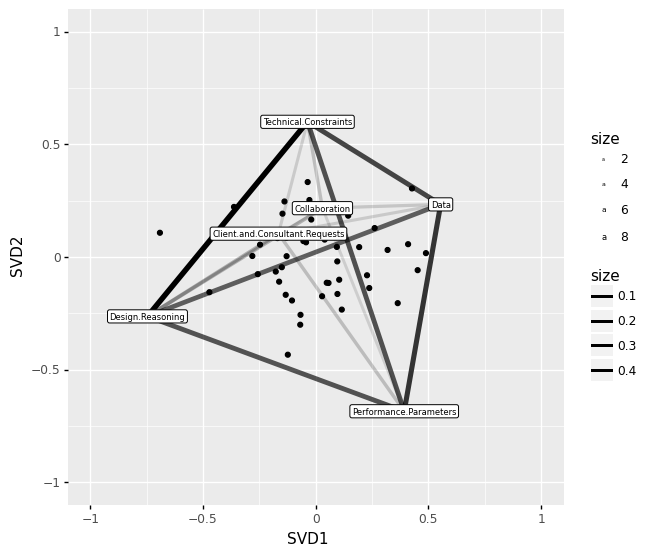

In [7]:
plot = ena_plot(enaset)
print(plot)

## Plot Units In Each Group

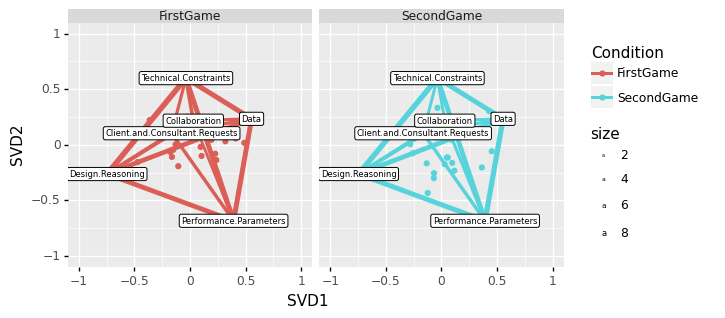

In [8]:
plot = ena_plot(enaset, "Condition", "facet")
print(plot)

## Plot Subtraction

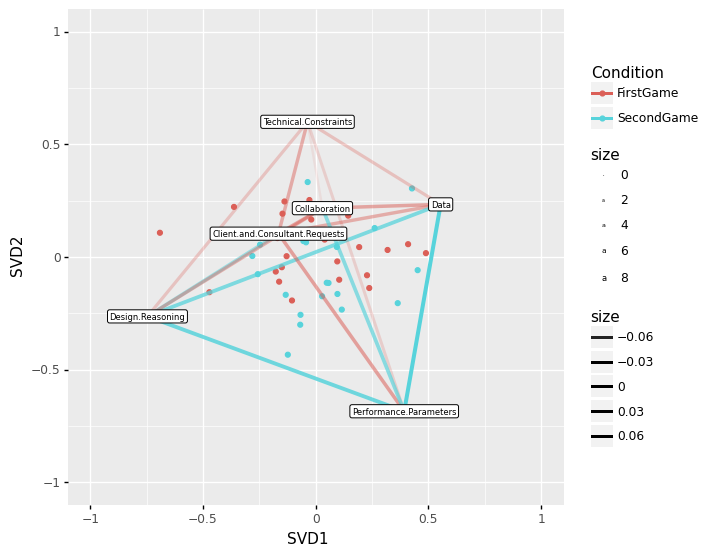

In [9]:
plot = ena_plot(enaset, "Condition", "subtract")
print(plot)